In [1]:
import numpy as np
import pandas as pd
import hist
from hist import Hist
import awkward as ak
import json
import uproot
import math
from coffea import util
import pandas as pd
import pickle
from coffea.hist import clopper_pearson_interval, poisson_interval

import matplotlib.pyplot as plt
import mplhep
plt.style.use(mplhep.style.CMS)

/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4/Tue/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/util.py:154: FutureWarning: In coffea version v2023.3.0 (target date: 31 Mar 2023), this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
ImportError: coffea.hist is deprecated
  warnings.warn(message, FutureWarning)


In [2]:
out_dir = "../outfiles/Run3Summer22EE/cutflow/wo_n2ddt_ddb_jet_arbitration"

era = "Run3Summer22EE"

# Table of contents <a class="anchor" id="toc"></a>

* [Plot pass/fail](#plot)
* [Plot pass/fail pt bins](#plot-pt)

# Plot pass/fail <a class="anchor" id="plot"></a>
[TOC](#toc)

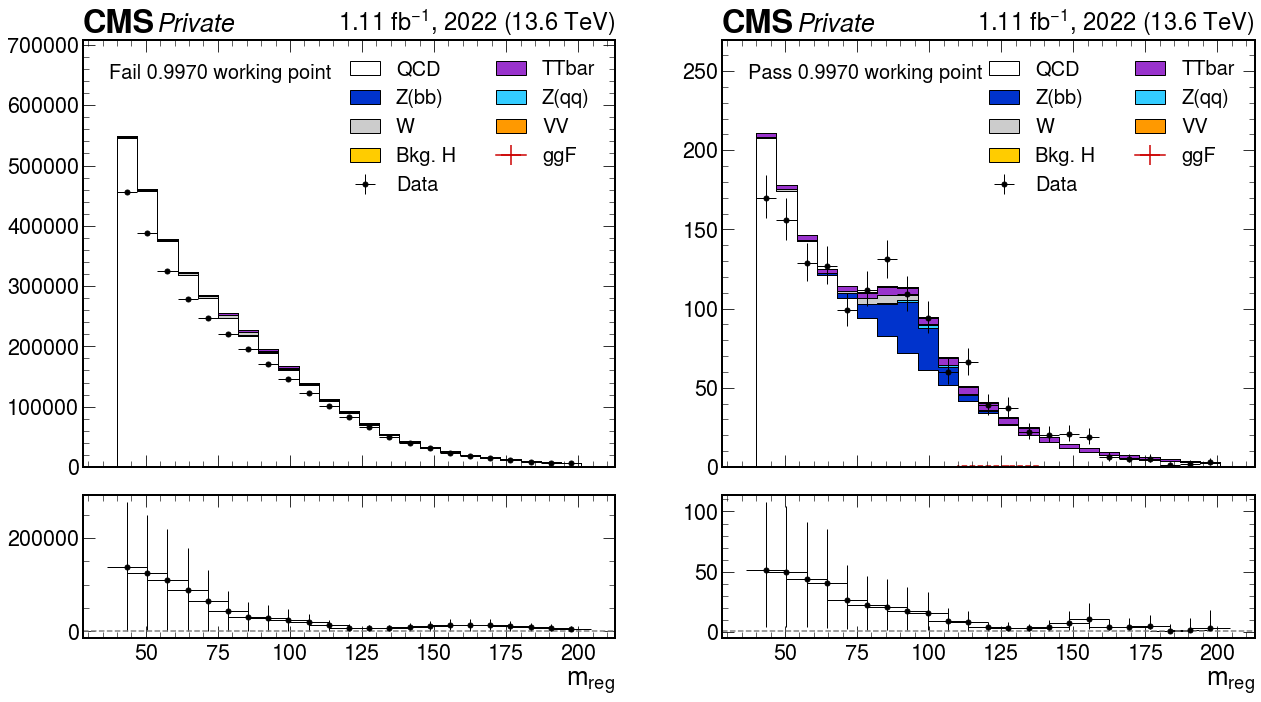

In [5]:
plt.style.use(mplhep.style.CMS)

mc = pickle.load(open(f'{out_dir}/mc.pkl','rb'))
lumi = mc['lumi']
mc = mc["hist"]
data = pickle.load(open(f'{out_dir}/data.pkl','rb'))

colour = {
    "QCD" : "white",
    "Z(bb)" : "#0033cc",
    "Z(qq)" : "#33ccff",
    "W" : "#cccccc",
    "TTbar" : "#9933cc",
#     "Single t" : "#ff66cc",
    "VV" : "#ff9900",
    "Bkg. H" : "#ffcc00",
}

wp = 9
blind = True
wps = mc.project('disc').axes[0].edges[:-1]
# 0 -0.1
# 1 0.8167194
# 2 0.95448214
# 3 0.9707
# 4 0.9782
# 5 0.9859 <--- max sign.
# 6 0.9864132
# 7 0.9945
# 8 0.9962
# 9 0.997
# 10 0.9984
# 11 0.9988
# 12 0.9991
# 13 0.9994

def get_sel(h, region, process):
    
    alias = {
        "Z(bb)" : hist.loc("ZJets"),
        "Z(qq)" : hist.loc("ZJets"),
        "All mc" : sum,
    }
    
    sel = {
        "pt" : slice(0, len, sum),
        "cut" : -1,
        "process" : alias[process] if process in alias.keys() else hist.loc(process),
    }
    
    h = h[sel]
    
    if process == "Z(bb)":
        h = h[{"genflav" : slice(3, 4, sum)}]
    elif process == "Z(qq)":
        h = h[{"genflav" : slice(1, 3, sum)}]
    else:
        h = h[{"genflav" : slice(0, len, sum)}]
        
    if "Pass" in region and process == "QCD":
        h = h * (h.project("disc")[wp:len:sum].value / h.project("disc")[0:wp:sum].value)
        h = h[{"disc" : slice(0, wp, sum)}]
    elif "Pass" in region and process != "QCD":
        h = h[{"disc" : slice(wp, len, sum)}]
    else:
        h = h[{"disc" : slice(0, wp, sum)}]
        
    if process == "data" and region == "Pass":
        for i in [12, 13, 14, 15]:
                h[i] = [np.nan, np.nan]
        
    return h


fig, ((ax1, ax2), (rax1, rax2)) = plt.subplots(
    2, 2, figsize=(21, 11), gridspec_kw={"height_ratios": (3, 1)}, sharex=True
)
fig.subplots_adjust(hspace=0.1)

for region, ax, rax in [("Fail", ax1, rax1), ("Pass", ax2, rax2)]:
    
    ax.set_xlabel(" ")
    rax.set_xlabel(r"$m_{reg}$")
    
    hs = []
    labels = []
    colours = []

    for process in colour.keys():
        
        h = get_sel(mc, region, process)
                    
        hs.append(h)
        labels.append(process)
        colours.append(colour[process])

    mplhep.histplot(
        hs,
        ax=ax,
        label=labels,
        stack=True,
        color=colours,
        histtype="fill",
        edgecolor="black",
        linewidth=1,
        flow="none",
    )
    
    h_ggF = get_sel(mc, region, "ggF")

    mplhep.histplot(
        h_ggF, 
        ax=ax, 
        color="#cc0000",
        label=f"ggF",
        linestyle="dashed",
        flow="none",
    )
            
    h_data = get_sel(data, region, "Run3Summer22EE")

    mplhep.histplot(
        h_data, 
        ax=ax, 
        histtype="errorbar",
        xerr=True,
        c="black",
        label=f"Data",
        flow="none",
    )
    
    h_mc = get_sel(mc, "All mc", process)
    
    centers = h_data.axes[0].centers
    sumw_num, sumw2_num = h_data.values(), h_data.variances()
    sumw_denom, sumw2_denom = h_mc.values(), h_mc.variances()
    
    rsumw = sumw_num / np.maximum(1, sumw_denom)
    rsumw_unc = poisson_interval(
        rsumw,
        sumw2_num / sumw_denom**2
    )
    
    data_err_opts = {
        'linestyle': 'none',
        'marker': '.',
        'markersize': 10.,
        'color': 'k',
        'elinewidth': 1,
    }
    
    rax.errorbar(
        centers,
        rsumw,
        xerr=centers[1]-centers[0],
        yerr=rsumw_unc,
        **data_err_opts,
    )
    
    rax.axhline(1, color='gray',ls='--')

    plt.text(0.05, 0.9, f"{region} {wps[wp]:.4f} working point",
                fontsize=20,
                horizontalalignment='left',
                verticalalignment='bottom',
                transform=ax.transAxes
               )

    mplhep.cms.label(
            ax=ax, 
            data=True, 
            fontsize=25,
            label="Private",
            year=2022,
            lumi=f"{lumi/1000:.2f}",
            com=13.6,
            )
    
    handles, labels = ax.get_legend_handles_labels()
    order = [0, 1, 3, 6, 8, 4, 2, 5, 7]
    ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=20, ncols=2)
    
    ax.set_ylim(0, max(hs[0].values()) * 1.3)

# Plot pass/fail pt bins <a class="anchor" id="plot-pt"></a>
[TOC](#toc)

300 < pt < 350
Z(bb) eff.: 5.99 %

300 < pt < 350
ggF eff.: 3.19 %

350 < pt < 400
Z(bb) eff.: 6.61 %

350 < pt < 400
ggF eff.: 4.58 %

400 < pt < 450
Z(bb) eff.: 6.68 %

400 < pt < 450
ggF eff.: 6.70 %

450 < pt < 500
Z(bb) eff.: 6.86 %

450 < pt < 500
ggF eff.: 7.24 %

500 < pt < 1200
Z(bb) eff.: 7.29 %

500 < pt < 1200
ggF eff.: 8.44 %



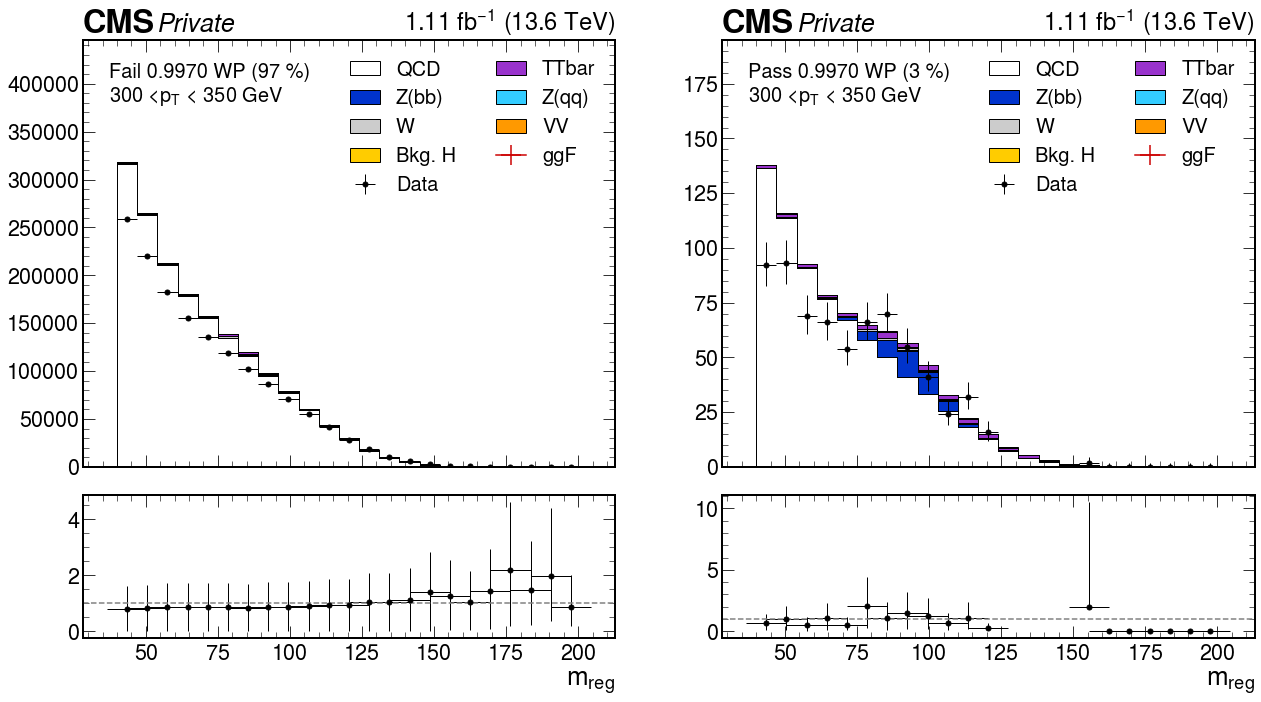

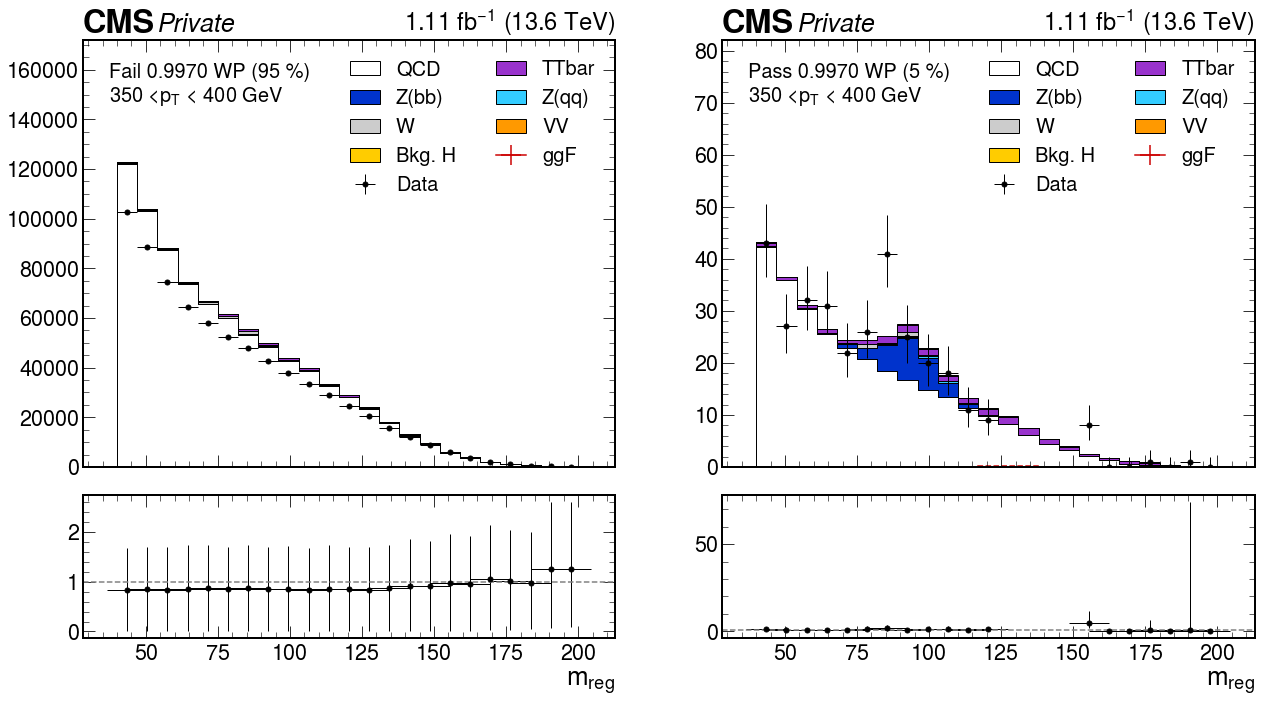

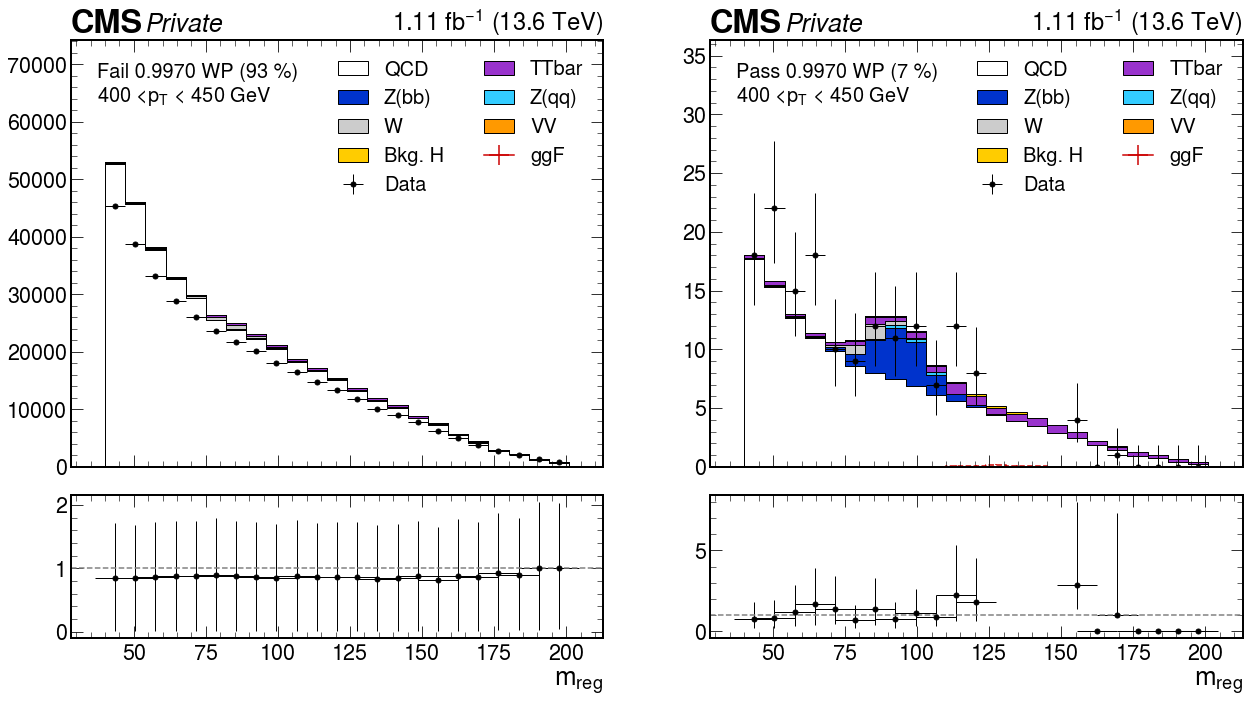

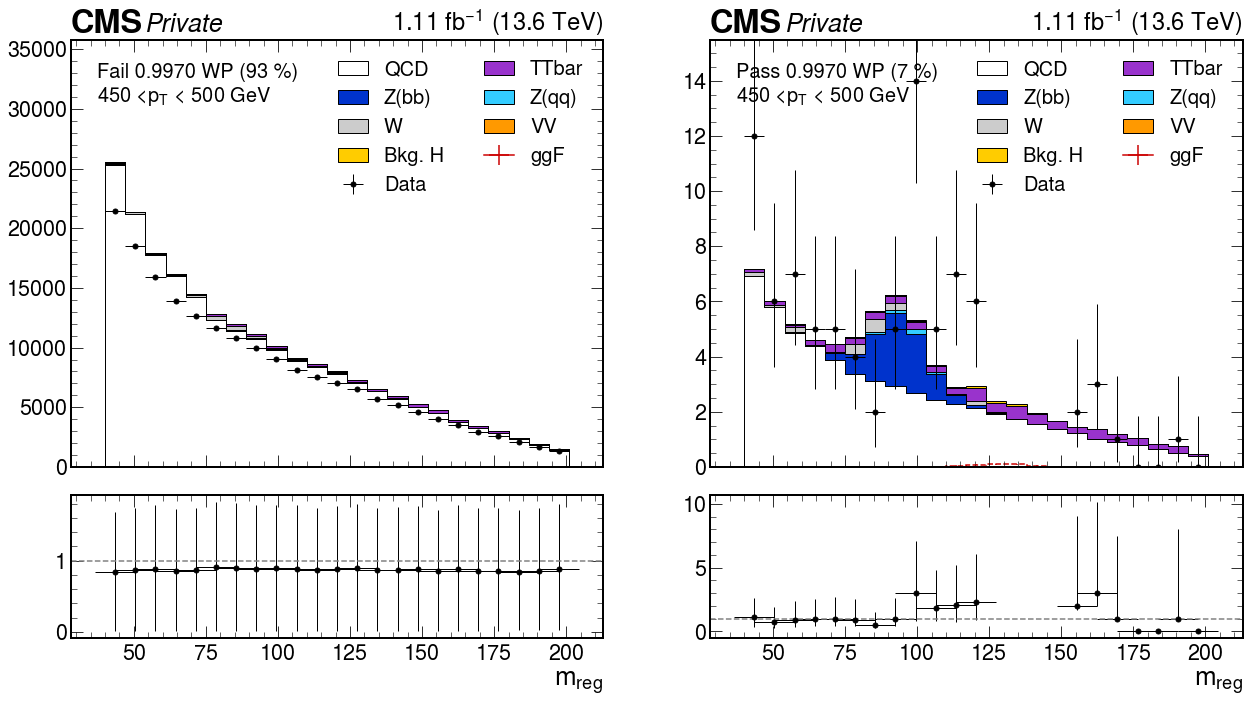

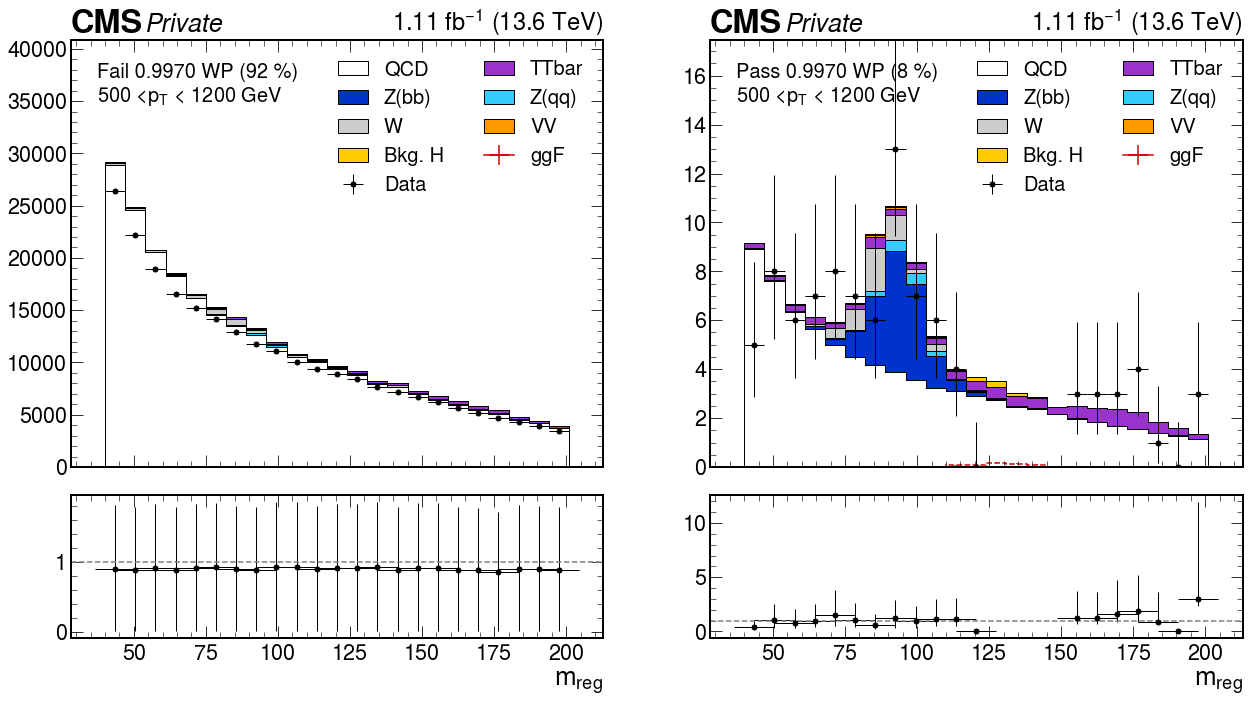

In [6]:
plt.style.use(mplhep.style.CMS)

mc = pickle.load(open(f'{out_dir}/mc.pkl','rb'))
lumi = mc['lumi']
mc = mc["hist"]
data = pickle.load(open(f'{out_dir}/data.pkl','rb'))

colour = {
    "QCD" : "white",
    "Z(bb)" : "#0033cc",
    "Z(qq)" : "#33ccff",
    "W" : "#cccccc",
    "TTbar" : "#9933cc",
#     "Single t" : "#ff66cc",
    "VV" : "#ff9900",
    "Bkg. H" : "#ffcc00",
}

wp = 9
blind = True
wps = mc.project('disc').axes[0].edges[:-1]
# 0 -0.1
# 1 0.8167194
# 2 0.95448214
# 3 0.9707
# 4 0.9782
# 5 0.9859
# 6 0.9864132
# 7 0.9945
# 8 0.9962
# 9 0.997
# 10 0.9984
# 11 0.9988
# 12 0.9991
# 13 0.9994

wp_pt = {
    300 : 3,
    350 : 4,
    400 : 8,
    450 : 9,
    500 : 13,
    550 : 12,
    600 : 7,
    675 : 11,
    800 : 10,
}

region = "Pass"

def get_eff(h_pass, h_tot):
    return h_pass.sum().value / h_tot.sum().value * 100

def get_sel(h, region, process, pt1, pt2, isData=False):
    
    eff = None
    
    alias = {
        "Z(bb)" : hist.loc("ZJets"),
        "Z(qq)" : hist.loc("ZJets"),
        "All mc" : sum,
    }
    
    sel = {
        "pt" : slice(hist.loc(pt1), hist.loc(pt2), sum),
        "cut" : -1,
        "process" : alias[process] if process in alias.keys() else hist.loc(process),
    }
    
    h = h[sel]
    
    if process == "Z(bb)":
        h = h[{"genflav" : slice(3, 4, sum)}]
    elif process == "Z(qq)":
        h = h[{"genflav" : slice(1, 3, sum)}]
    else:
        h = h[{"genflav" : slice(0, len, sum)}]
        
    if "Pass" in region and process == "QCD":
        h = h * (h.project("disc")[wp:len:sum].value / h.project("disc")[0:wp:sum].value)
        h = h[{"disc" : slice(0, wp, sum)}]

    if "Pass" in region and process != "QCD":
        h_tot = h
        h = h[{"disc" : slice(wp, len, sum)}]
        
        if process == "ggF" or process == "Z(bb)":
            eff = get_eff(h, h_tot[{"disc" : sum}])
            print(f"{pt1} < pt < {pt2}")
            print(f"{process} eff.: {eff:.2f} %")
            print()
        
    elif "Fail" in region:
        h_tot = h
        h = h[{"disc" : slice(0, wp, sum)}]
        
        if process == "ggF":
            eff = get_eff(h, h_tot[{"disc" : sum}])
        
    if isData and region == "Pass":
        for i in [12, 13, 14, 15]:
                h[i] = [np.nan, np.nan]
                        
    return h, eff

# pt_edges = mc.project("pt").axes[0].edges[1:]
pt_edges = [300, 350, 400, 450, 500, 1200]

for pt_i, pt in enumerate(pt_edges):
    
    if pt_i == len(pt_edges) -1:
        break
        
#     wp = wp_pt[pt]
    
    pt1 = pt
    pt2 = pt_edges[pt_i + 1]
    
    fig, ((ax1, ax2), (rax1, rax2)) = plt.subplots(
        2, 2, figsize=(21, 11), gridspec_kw={"height_ratios": (3, 1)}, sharex=True
    )
    fig.subplots_adjust(hspace=0.1)

    for region, ax, rax in [("Fail", ax1, rax1), ("Pass", ax2, rax2)]:

        ax.set_xlabel(" ")
        rax.set_xlabel(r"$m_{reg}$")

        hs = []
        labels = []
        colours = []

        for process in colour.keys():

            h, _ = get_sel(mc, region, process, pt1, pt2)

            hs.append(h)
            labels.append(process)
            colours.append(colour[process])

        mplhep.histplot(
            hs,
            ax=ax,
            label=labels,
            stack=True,
            color=colours,
            histtype="fill",
            edgecolor="black",
            linewidth=1,
            flow="none",
        )

        h_ggF, eff = get_sel(mc, region, "ggF", pt1, pt2)

        mplhep.histplot(
            h_ggF, 
            ax=ax, 
            color="#cc0000",
            label=f"ggF",
            linestyle="dashed",
            flow="none",
        )

        h_data, _ = get_sel(data, region, "Run3Summer22EE", pt1, pt2, isData=True)

        mplhep.histplot(
            h_data, 
            ax=ax, 
            histtype="errorbar",
            xerr=True,
            c="black",
            label=f"Data",
            flow="none",
        )

        h_mc, _ = get_sel(mc, region, "All mc", pt1, pt2)

        centers = h_data.axes[0].centers
        sumw_num, sumw2_num = h_data.values(), h_data.variances()
        sumw_denom, sumw2_denom = h_mc.values(), h_mc.variances()

        rsumw = sumw_num / np.maximum(1, sumw_denom)
        rsumw_unc = poisson_interval(
            rsumw,
            sumw2_num / sumw_denom**2
        )

        data_err_opts = {
            'linestyle': 'none',
            'marker': '.',
            'markersize': 10.,
            'color': 'k',
            'elinewidth': 1,
        }

        rax.errorbar(
            centers,
            rsumw,
            xerr=centers[1]-centers[0],
            yerr=rsumw_unc,
            **data_err_opts,
        )

        rax.axhline(1, color='gray',ls='--')
        
        plt.text(0.05, 0.84, f"{region} {wps[wp]:.4f} WP ({eff:.0f} %)\n{pt1:.0f} <" + r"$p_T$" + f" < {pt2:.0f} GeV",
                    fontsize=20,
                    horizontalalignment='left',
                    verticalalignment='bottom',
                    transform=ax.transAxes
                   )

        mplhep.cms.label(
                ax=ax, 
                data=True, 
                fontsize=25,
                label="Private",
#                 year=2022,
                lumi=f"{lumi/1000:.2f}",
                com=13.6,
                )

        handles, labels = ax.get_legend_handles_labels()
        order = [0, 1, 3, 6, 8, 4, 2, 5, 7]
        ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order], fontsize=20, ncols=2)

        ax.set_ylim(0, max(h_mc.values()) * 1.4)